Original post: [Exploring response time distributions using Python](http://www.marsja.se/response-time-distributions-using-python/)

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

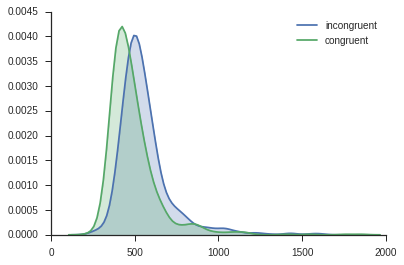

In [2]:
# Example data
frame = pd.read_csv('flanks.csv', sep=',')

# Kernel estimation plot
def kde_plot(df, conditions, dv, col_name, save_file=False):
    """
    Creates kernel density estimation plots 
    
    Parameters
    ----------
    conditions : list
        Strings of your conditions (e.g., ['congruent', 'incongruent'])
    dv : string
        Column name for the dependent variable (e.g., response time)
    col_name : string
        Column name for the column containing condition levels
    save_file: boolean
        True if image file is to be saved
    
    """
    sns.set_style('white')
    sns.set_style('ticks')
    fig, ax = plt.subplots()

    for condition in conditions:
        condition_data = df[(df[col_name] == condition)][dv]
        sns.kdeplot(condition_data, shade=True, label=condition)
        
    sns.despine()
    
    if save_file:
        plt.savefig("kernel_density_estimate_seaborn_python_response"
                     "-time.png")
    plt.show()
    
kde_plot(frame, ['incongruent', 'congruent'], 'RT', 'TrialType',
         save_file=False)

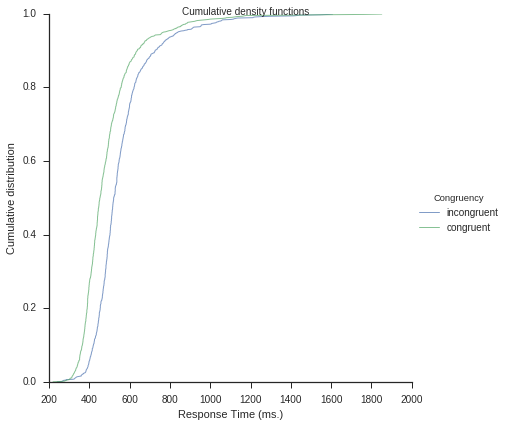

In [3]:
def cdf(df, conditions=['congruent', 'incongruent']):
    """
    Calculates the cumulative distribution function (CDF)
    
    Parameters
    ----------
    df : pandas dataframe
    conditions : list
        Containing strings of each condition
        
    Returns
    -------
    plot_data : pandas dataframe
        CDFs for each condition
        
    Examples
    --------
    cdf_dat = cdf(frame, conditions=['incongruent', 'congruent'])
    
    """

    data = {i: df[(df.TrialType == conditions[i])] for i in range(len(
        conditions))}
    plot_data = []

    for i, condition in enumerate(conditions):

        rt = data[i].RT.sort_values()
        yvals = np.arange(len(rt)) / float(len(rt))

        # Append it to the data
        cond = [condition]*len(yvals)

        df = pd.DataFrame(dict(dens=yvals, dv=rt, condition=cond))
        plot_data.append(df)

    plot_data = pd.concat(plot_data, axis=0)

    return plot_data


def cdf_plot(cdf_data, save_file=False, legend=True, im_size=6):
    """
    Plot the cumulative distribution functions
    
    Parameters
    ----------
    cdf_data : pandas dataframe
        Pre-calculated cumulative distribution functions 
    save_file : boolean
        True if image (png) is going to be saved
    legend : boolean
        True if legend on plot
    im_size : integer
        Size of the image (i.e., the plot)
    
    Examples
    --------
    cdf_dat = cdf(frame, conditions=['incongruent', 'congruent'])
    cdf_plot(cdf_dat)
    
    """
    sns.set_style('white')
    sns.set_style('ticks')

    g = sns.FacetGrid(cdf_data, hue="condition", size=im_size)
    g.map(plt.plot, "dv", "dens", alpha=.7, linewidth=1)
    if legend:
        g.add_legend(title="Congruency")
    g.set_axis_labels("Response Time (ms.)", "Cumulative distribution")
    g.fig.suptitle('Cumulative density functions')

    if save_file:
        g.savefig("cumulative_density_functions_seaborn_python_response"
                  "-time.png")

    plt.show()

# Cumulatitive distribution function and plot
cdf_dat = cdf(frame, conditions=['incongruent', 'congruent'])
cdf_plot(cdf_dat, legend=True, save_file=True)

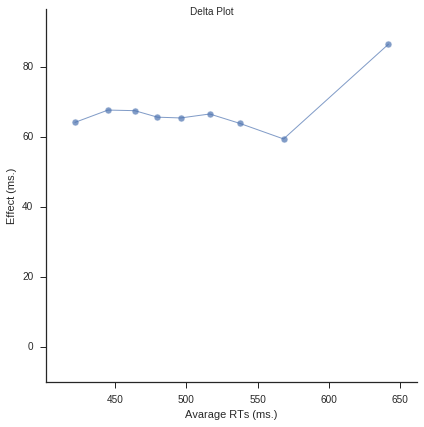

In [4]:
def calc_delta_data(df, subid, rt, condition, conditions=['incongruent',
                                                   'congruent']):
    """
    Calculating the data for creating delta plots. That is, binning
    the response time and accuracy data in deciles. First each subjects
    data is binned. Then the binned data is avaraged.
    
    Parameters
    ----------
    df : pandas dataframe
        Data to bin.
    subid : string
        Column name for column with the subject identfier
    rt : string
        Column name for column with the response times
    condition : string
        Column name for column with the conditions
    conditions : list
        Containing string of the conditions in the experiment
        
    Returns
    -------
    delta_data: Dataframe
        Binned avarage response time and response time diff b/w conditions 
        
    Examples
    --------
    d = calc_delta_data(frame, "SubID", "RT", "TrialType", ['incongruent',
                                                       'congruent'])
    
    """


    subjects = pd.Series(df[subid].values.ravel()).unique().tolist()
    subjects.sort()

    deciles = np.arange(0.1, 1., 0.1)

    cond_one = conditions[0]
    cond_two = conditions[1]

    # Frame to store the data (per subject)
    arrays = [np.array([cond_one, cond_two]).repeat(len(deciles)),
              np.array(deciles).tolist() * 2]
    data_delta = pd.DataFrame(columns=subjects, index=arrays)

    for subject in subjects:

        sub_data_inc = df.loc[(df[subid] == subject) & (df[condition] ==
                                                        cond_one)]
        sub_data_con = df.loc[(df[subid] == subject) & (df[condition] ==
                                                        cond_two)]

        inc_q = sub_data_inc[rt].quantile(q=deciles).values
        con_q = sub_data_con[rt].quantile(q=deciles).values
        for i, dec in enumerate(deciles):
            data_delta.loc[(cond_one, dec)][subject] = inc_q[i]
            data_delta.loc[(cond_two, dec)][subject] = con_q[i]


    # Aggregate deciles
    data_delta = data_delta.mean(axis=1).unstack(level=0)
    # Calculate difference
    data_delta['Diff'] = data_delta[cond_one] - data_delta[cond_two]
    # Calculate average
    data_delta['Average'] = (data_delta[cond_one] + data_delta[cond_two]) / 2

    return data_delta


def delta_plot(delta_data, save_file=False, im_size=6):
    """
    Delta plot
    
    Parameters
    ----------
    delta_data : pandas dataframe
        Binned avarage response time and response time diff b/w conditions 
    save_file : boolean
        True if file (.png) of plot is going to be saved
    im_size : integer
        Size of the image (i.e., the plot)
        
    Examples
    -------
    d = calc_delta_data(frame, "SubID", "RT", "TrialType", ['incongruent',
                                                       'congruent'])
    delta_plot(d, save_file=True)
    """

    ymax = delta_data['Diff'].max() + 10
    ymin = -10
    xmin = delta_data['Average'].min() - 20
    xmax = delta_data['Average'].max() + 20

    g = sns.FacetGrid(delta_data, ylim=(ymin, ymax), xlim=(xmin, xmax),
                      size=im_size)
    g.map(plt.scatter, "Average", "Diff", s=50, alpha=.7, linewidth=1,
          edgecolor="white")
    g.map(plt.plot, "Average", "Diff", alpha=.7, linewidth=1)
    g.set_axis_labels("Avarage RTs (ms.)", "Effect (ms.)")
    g.fig.suptitle('Delta Plot')
    if save_file:
        g.savefig("delta_plot_seaborn_python_response-time.png")

    plt.show()

    sns.plt.show()
    

d = calc_delta_data(frame, "SubID", "RT", "TrialType", ['incongruent',
                                                       'congruent'])

delta_plot(d, save_file=True)

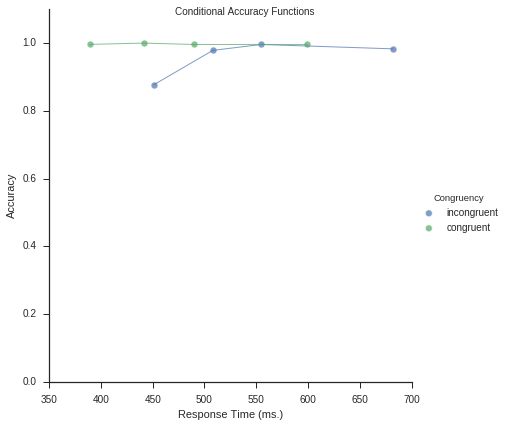

In [5]:
def calc_caf(df, subid, rt, acc, condition, quantiles=[0.25, 0.50, 0.75, 1]):
    """
    Calculates conditional accuracy functions (CAF) per subject and agregates into 
    one CAF. 
    
    Parameters
    ----------
    df : pandas dataframe
        A subset containing the data from one of the conditions
    subid : string
        Contains the colum name with the subject identifier
    rt : string 
        column name for column containing the response/reaction times
    acc : string  
        column name for column containing the accuracy data
    condition :string 
        column name for column containing the conditions identfiers
    quantiles: list 
        contains the quantiles (e.g., [0.25, 0.50, 0.75, 1])

    Returns
    -------
        a multi-indexed pandas data frame

    Examples:
     incongr = frame[(frame.TrialType == 'incongruent)]
     incongr_caf = calc_caf(incongr, "SubID", "RT", "ACC", "incongruent")
    """

    # Subjects
    subjects = pd.Series(df[subid].values.ravel()).unique().tolist()
    subjects.sort()

    # Multi-index frame for data:
    arrays = [np.array(['rt'] * len(quantiles) + ['acc'] * len(quantiles)),
              np.array(quantiles * 2)]

    data_caf = pd.DataFrame(columns=subjects, index=arrays)

    # Calculate CAF for each subject
    for subject in subjects:

        sub_data = df.loc[(df[subid] == subject)]

        subject_cdf = sub_data[rt].quantile(q=quantiles).values

        # calculate mean response time and proportion of error for each bin
        for i, q in enumerate(subject_cdf):

            quantile = quantiles[i]

            # First quantile
            if i < 1:
                # Subset
                temp_df = sub_data[(sub_data[rt] < subject_cdf[i])]
                # RT
                data_caf.loc[('rt', quantile)][subject] = temp_df[rt].mean()
                # Accuracy
                data_caf.loc[('acc', quantile)][subject] = temp_df[acc].mean()

            # Second  & third quantile
            elif i == 1 or i < len(quantiles):

                # Subset
                temp_df = sub_data[(sub_data[rt] > subject_cdf[i - 1]) & (
                    sub_data[rt] < q)]
                # RT
                data_caf.loc[('rt', quantile)][subject] = temp_df[rt].mean()

                # Accuracy
                data_caf.loc[('acc', quantile)][subject] = temp_df[acc].mean()

            # Last quantile MAY WANT TO CHANGE THIS
            elif i == len(quantiles):
                # Subset
                temp_df = sub_data[(sub_data[rt] > subject_cdf[i])]

                # RT
                data_caf.loc[('rt', quantile)][subject] = temp_df[rt].mean()

                # Accuracy
                data_caf.loc[('acc', quantile)][subject] = temp_df[acc].mean()

    # Aggregate subjects CAFs
    data_caf = data_caf.mean(axis=1).unstack(level=0)

    # Add trialtype
    data_caf['trialtype'] = [condition for _ in range(len(quantiles))]

    return data_caf


def caf_plot(df, save_file=False, im_size=6):
    """
    Plotting the conditional accuracy functions (CAF)
    
    Parameters
    ----------
    df : pandas dataframe 
        containing the CAF(s) calculated with calc_caf
    save_file : boolean
        True if planning to save file
    im_size : integer
        Size of the image (i.e., the plot)
        
    Examples
    --------
    incongr = frame[(frame.TrialType == 'incongruent)]
    incongr_caf = calc_caf(incongr, "SubID", "RT", "ACC", "incongruent")
    caf_plot(incongr_caf)
    """
    sns.set_style('white')
    sns.set_style('ticks')

    g = sns.FacetGrid(df, hue="trialtype", size=im_size, ylim=(0, 1.1))
    g.map(plt.scatter, "rt", "acc", s=50, alpha=.7, linewidth=1,
          edgecolor="white")
    g.map(plt.plot, "rt", "acc", alpha=.7, linewidth=1)
    g.add_legend(title="Congruency")
    g.set_axis_labels("Response Time (ms.)", "Accuracy")
    g.fig.suptitle('Conditional Accuracy Functions')

    if save_file:
        g.savefig("conditional_accuracy_function_seaborn_python_response"
                   "-time.png")

    plt.show()


inc = calc_caf(frame[(frame.TrialType == "incongruent")], "SubID", "RT",
               "ACC",
               "incongruent", quantiles=[.25, .50, .75, 1.])
con = calc_caf(frame[(frame.TrialType == "congruent")], "SubID", "RT", "ACC",
               "congruent")
df_caf = pd.concat([inc, con])

caf_plot(df_caf, save_file=True)

